In [1]:
# !pip install -U segmentation-models-pytorch albumentations --user 
!pip install albumentations
!pip install -U imgaug
!pip install -U albumentations[imgaug]

!pip list | grep imgaug

zsh:1: no matches found: albumentations[imgaug]
imgaug                      0.4.0


In [7]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [19]:
DATA_DIR = '/Users/jinseokhong/data/data/CamVid/'

# load repo with data if it is not exists
if not os.path.exists(DATA_DIR):
    print('Loading data...')
    os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial /Users/jinseokhong/data/data')
    print('Done!')

In [20]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [21]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [22]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [23]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

(360, 480, 3) (360, 480, 1)


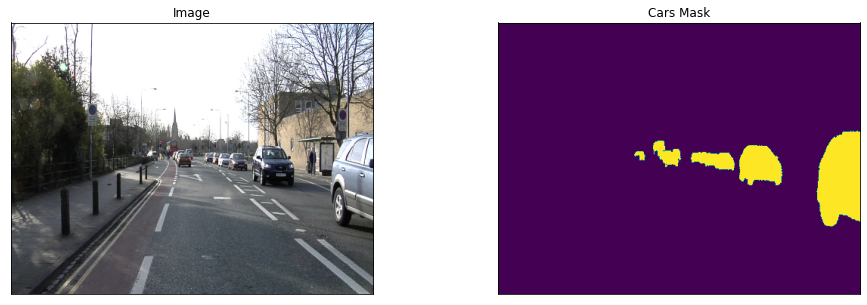

In [24]:
# Lets look at data we have

dataset = Dataset(x_train_dir, y_train_dir, classes=['car'])

image, mask = dataset[4] # get some sample
print(image.shape, mask.shape)
visualize(
    image=image, 
    cars_mask=mask.squeeze(),
)

In [25]:
!pip list | grep album
import albumentations as albu

albumentations              1.1.0


In [26]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

/Users/jinseokhong/miniforge3/envs/torch/lib/python3.8/site-packages/albumentations/imgaug/transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/Users/jinseokhong/miniforge3/envs/torch/lib/python3.8/site-packages/albumentations/imgaug/transforms.py:375: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/Users/jinseokhong/miniforge3/envs/torch/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1800: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/Users/jinseokhong/miniforge3/envs/torch/lib/python3.8/site-packages/albumentations/imgaug/transforms.py:222: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.war

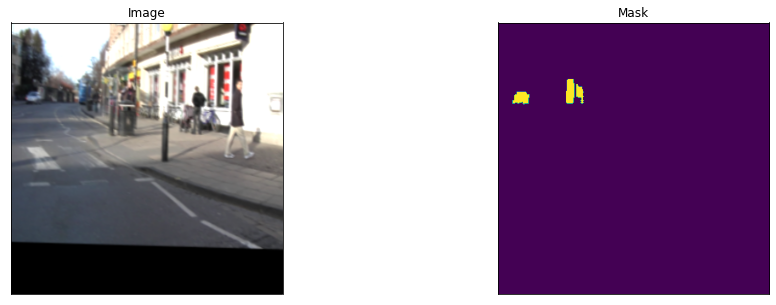

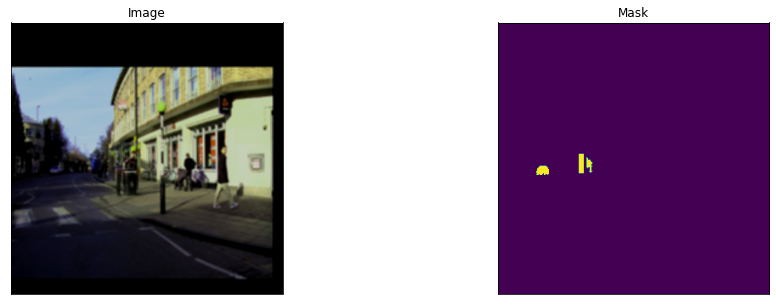

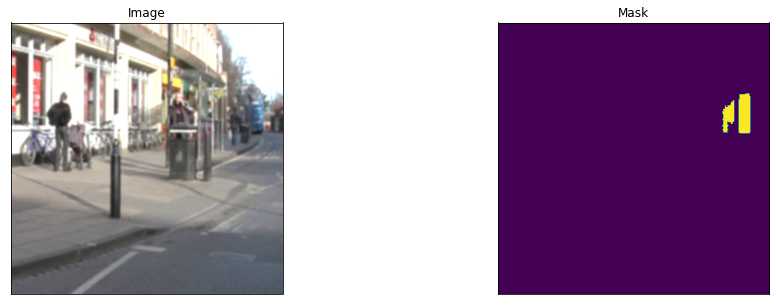

In [27]:

#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=['car'],
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[1]
    visualize(image=image, mask=mask.squeeze(-1))

In [28]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [29]:
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['car']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'mps'

# create segmentation model with pretrained encoder
model = smp.DeepLabV3(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [30]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)

/Users/jinseokhong/miniforge3/envs/torch/lib/python3.8/site-packages/albumentations/imgaug/transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/Users/jinseokhong/miniforge3/envs/torch/lib/python3.8/site-packages/albumentations/imgaug/transforms.py:375: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/Users/jinseokhong/miniforge3/envs/torch/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1800: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/Users/jinseokhong/miniforge3/envs/torch/lib/python3.8/site-packages/albumentations/imgaug/transforms.py:222: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.war

In [31]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [32]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [33]:
# train model for 40 epochs

max_score = 0

for i in range(0, 40):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train:   2%|▏         | 1/46 [00:09<07:18,  9.73s/it, dice_loss - 1.0, iou_score - nan]


KeyboardInterrupt: 